# Generate figures for first synthetic MRSI simulation

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
base_path = Path('synthetic_fits_1')

In [3]:
mask = np.atleast_3d(nib.load('noisy_synthetic_data/mask.nii.gz').get_fdata())
mask = np.array(mask, dtype=bool)

## Standard deviation for each method
Compare the actual SD vs the fitting predicted (estimated from the baseline noise)

In [4]:
df_acumulator = []
total_files = len(list(base_path.rglob('molarity/*.nii.gz')))
for idx, path in enumerate(base_path.rglob('molarity/*.nii.gz')):
#     print(path)
    metab = path.name[:-7]
    index = int(path.parent.parent.parent.name[-3:])
    denoising = path.parent.parent.parent.parent.name
    data = nib.load(path).get_fdata()[mask]
    voxels = np.arange(0, data.size)
    
    iterables = [[denoising], [metab], voxels, [index]]
    index = pd.MultiIndex.from_product(iterables, names=["method", "metabolite", "voxels", "index"])
    df_acumulator.append(pd.Series(data, index=index))
    
#     if idx == 5:
#         break
    if not idx % 500:
        print(f'{idx}/{total_files} done')
    
df_molarity = pd.concat(df_acumulator,join='inner')

0/8700 done
500/8700 done
1000/8700 done
1500/8700 done
2000/8700 done
2500/8700 done
3000/8700 done
3500/8700 done
4000/8700 done
4500/8700 done
5000/8700 done
5500/8700 done
6000/8700 done
6500/8700 done
7000/8700 done
7500/8700 done
8000/8700 done
8500/8700 done


In [5]:
df_acumulator = []
total_files = len(list(base_path.rglob('uncertainties/*.nii.gz')))
for idx, path in enumerate(base_path.rglob('uncertainties/*.nii.gz')):
#     print(path)
    metab = path.name[:-10]
    index = int(path.parent.parent.name[-3:])
    denoising = path.parent.parent.parent.name
    data = nib.load(path).get_fdata()[mask]
    voxels = np.arange(0, data.size)
    
    iterables = [[denoising], [metab], voxels, [index]]
    index = pd.MultiIndex.from_product(iterables, names=["method", "metabolite", "voxels", "index"])
    df_acumulator.append(pd.Series(data, index=index))
    
#     if idx == 5:
#         break
    if not idx % 500:
        print(f'{idx}/{total_files} done')
    
df_fit_crlb = pd.concat(df_acumulator,join='inner')

0/8700 done
500/8700 done
1000/8700 done
1500/8700 done
2000/8700 done
2500/8700 done
3000/8700 done
3500/8700 done
4000/8700 done
4500/8700 done
5000/8700 done
5500/8700 done
6000/8700 done
6500/8700 done
7000/8700 done
7500/8700 done
8000/8700 done
8500/8700 done


In [6]:
# Calculate the standard deviation of the fitted values across each condition
df_molarity_std = df_molarity.std(level=["method", "metabolite", "voxels"])
# Take the ratio to the noisy condition
df_mol_std_ratio = df_molarity_std.divide(df_molarity_std.xs(('noisy')))
# Remove any infs by setting to nan
df_mol_std_ratio.replace([np.inf, -np.inf], np.nan,inplace=True)

df_fit_crlb_no999 = df_fit_crlb.replace(999, np.nan)
df_fit_crlb_mean = df_fit_crlb_no999.mean(level=["method", "metabolite", "voxels"])
df_fit_crlb_mean_ratio = df_fit_crlb_mean.divide(df_fit_crlb_mean.xs(('noisy')))

## Calculate RMSEs
Calculated from a fit of the noiseless data

In [7]:
df_acumulator = []
noiseless_path = Path('noiseless_fit/')
total_files = len(list(noiseless_path.rglob('molarity/*.nii.gz')))
for idx, path in enumerate(noiseless_path.rglob('molarity/*.nii.gz')):
    metab = path.name[:-7]
    data = nib.load(path).get_fdata()[mask]
    voxels = np.arange(0, data.size)
    
    iterables = [[metab], voxels]
    index = pd.MultiIndex.from_product(iterables, names=["metabolite", "voxels"])
    df_acumulator.append(pd.Series(data, index=index))

    if not idx % 5:
        print(f'{idx}/{total_files} done')
    
df_noiseless = pd.concat(df_acumulator,join='inner')

0/29 done
5/29 done
10/29 done
15/29 done
20/29 done
25/29 done


In [8]:
df_rmse = df_molarity.subtract(df_noiseless).pow(2).mean(level=["method", "metabolite", "voxels"]).pow(0.5).divide(df_noiseless)
df_rmse = df_rmse.reorder_levels(["metabolite", "voxels","method"])
df_rmse.replace([np.inf, -np.inf], np.nan,inplace=True)

In [9]:
# Define groups of metabolites to calculate across
# df_molarity_std.index.unique(level=1)
metab_all_fitted = ['Cr', 'Tau', 'NAAG', 'MM14', 'GSH', 'Gln', 'Asp',
                    'Lac', 'Ins', 'MM12', 'PCr', 'MM17', 'MM09', 'Asc',
                    'MM21', 'Glu', 'GABA', 'Glc', 'Scyllo', 'GPC', 'PCho',
                    'NAA']
metab_all_large = ['Glu+Gln', 'Glc+Tau', 'PCho+GPC', 'NAA+NAAG', 'Ins', 'Cr+PCr']
metab_all_unique = ['Glu+Gln', 'Glc+Tau', 'PCho+GPC', 'MM14', 'GSH',
                    'Asp', 'NAA+NAAG', 'Lac', 'Ins', 'MM12', 'MM17', 'MM09',
                    'Asc', 'MM21', 'GABA', 'Scyllo', 'Cr+PCr']

## Generate numbers for the results section

In [23]:
method_order = ['noisy', 'st_g', 'st_l', 'lp', 'lo_g', 'lo_l']
metabs_to_use = metab_all_large
means_mc = df_mol_std_ratio.loc[metabs_to_use].mean(level=2)[method_order]
sd_mc = df_mol_std_ratio.loc[metabs_to_use].std(level=2)[method_order]
print('Large uncertainty ratios:', end='')
for mm,sd in zip(means_mc,sd_mc):
    print(f'{mm:0.2f}±{sd:0.2f}', end=', ')
    
metabs_to_use = metab_all_unique
means_mc = df_mol_std_ratio.loc[metabs_to_use].mean(level=2)[method_order]
sd_mc = df_mol_std_ratio.loc[metabs_to_use].std(level=2)[method_order]
print('\n\nUnique uncertainty ratios:', end='')
for mm,sd in zip(means_mc,sd_mc):
    print(f'{mm:0.2f}±{sd:0.2f}', end=', ')
    
print(f"\n\n{1 - df_fit_crlb_mean_ratio.loc[metab_all_large].mean(level=2)['st_g']/df_mol_std_ratio.loc[metab_all_large].mean(level=2)['st_g']:0.2f}")
print(f"{1 - df_fit_crlb_mean_ratio.loc[metab_all_large].mean(level=2)['st_l']/df_mol_std_ratio.loc[metab_all_large].mean(level=2)['st_l']:0.2f}")

rmse_x = [df_rmse.loc[metab_all_large].xs(method,level=2).to_numpy() for method in method_order]
rmse_x = [data[~np.isnan(data)] for data in rmse_x]
rmse_x = np.asarray(rmse_x)
print('\n\nMedian RMSE:', end='')
for rmse in np.median(rmse_x, axis=1):
    print(f'{rmse:0.3f}', end=', ')

Large uncertainty ratios:1.00±0.00, 0.67±0.20, 0.56±0.15, 1.07±0.20, 0.68±0.21, 0.57±0.15, 

Unique uncertainty ratios:1.00±0.00, 0.57±0.42, 0.57±0.34, 1.22±2.40, 0.58±0.38, 0.65±2.55, 

0.64
0.17


Median RMSE:0.062, 0.056, 0.050, 0.068, 0.057, 0.050, 

## Generate plots

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.rc('legend', fontsize=14)    # legend fontsize

def plot_unccertainty_rmse(metabs, out_path):
    labels = ['Noisy', 'Global ST', 'Local ST', 'LP', 'Global LORA', 'Local LORA']
    method_order = ['noisy', 'st_g', 'st_l', 'lp', 'lo_g', 'lo_l']

    metabs_to_use = metabs

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))

    # Pannel 1 - uncertainties
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    means_mc = df_mol_std_ratio.loc[metabs_to_use].mean(level=2)[method_order]
    means_fit = df_fit_crlb_mean_ratio.loc[metabs_to_use].mean(level=2)[method_order]

    sd_mc = df_mol_std_ratio.loc[metabs_to_use].std(level=2)[method_order]
    sd_fit = df_fit_crlb_mean_ratio.loc[metabs_to_use].std(level=2)[method_order]

    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in range(len(labels)-1)]
    colors = [(0,0,0,1),] + colors

    rects1 = ax1.bar(x - width/2, means_mc, width, yerr=sd_mc, label='MC', color=colors)
    rects2 = ax1.bar(x + width/2, means_fit, width, yerr=sd_fit, label='Fit',hatch='/',alpha=0.3, color=colors)
    ax1.set_ylabel('Uncertainty as fraction of "Noisy"')
    ax1.set_ylim(0.0, 2.0)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=60)
    ax1.legend()

    # Pannel 2 - RMSE
    # means_rmse = df_rmse.loc[metabs_to_use].mean(level=2)[method_order]
    # sd_rmse = df_rmse.loc[metabs_to_use].std(level=2)[method_order]
    rmse_x = [df_rmse.loc[metabs_to_use].xs(method,level=2).to_numpy() for method in method_order]
    rmse_x = [data[~np.isnan(data)] for data in rmse_x]

    # rects1 = ax2.bar(x, means_rmse, width, yerr=sd_rmse, color=colors)
    bplot = ax2.boxplot(rmse_x, positions=x, patch_artist=True)
    ax2.set_ylabel('NRMSE')
    ax2.set_ylim(0.0, 1.0)
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=60)

    # fill with colors
    for patch, meds, color in zip(bplot['boxes'],bplot['medians'], colors):
        patch.set_facecolor(color)
        meds.set_color('w')

    fig.text(0.055, 0.87,'a',fontweight='bold',fontsize=24)
    fig.text(0.495, 0.87,'b',fontweight='bold',fontsize=24)
        
    plt.savefig(out_path, bbox_inches='tight', dpi=300)
    
plot_unccertainty_rmse(metab_all_large,'figures/figure_7_syn_summary_rmse.png')
plot_unccertainty_rmse(metab_all_unique,'figures/supp_fig_5_syn_summary_rmse_all.png')

## Explanatory figure

In [2]:
from fsl_mrs.utils import mrs_io

noisy_syn_path = Path('noisy_synthetic_data')
noisy_syn_name = 'noisy_synthetic_scale*__000.nii.gz'
noisy_fids = []
noise_scaling = []
for fp in noisy_syn_path.rglob(noisy_syn_name):
    nmrs = mrs_io.read_FID(fp)
    noisy_fids.append(nmrs.mrs().mrs_by_index((24,24,0)))
    noise_scaling.append(float(fp.parent.name.lstrip('noise_')))

noisy_fids = [nf for _, nf in sorted(zip(noise_scaling,noisy_fids), key=lambda pair: pair[0])]
noise_scaling = sorted(noise_scaling)


In [3]:
denoise_path = Path('synthetic_fits_1/')
denoise_name = 'denoise_000.nii.gz'
denoised_fids = {}
for fp in denoise_path.rglob(denoise_name):
    nmrs = mrs_io.read_FID(fp)
    denoised_fids[fp.parent.name] = nmrs.mrs().mrs_by_index((24,24,0))

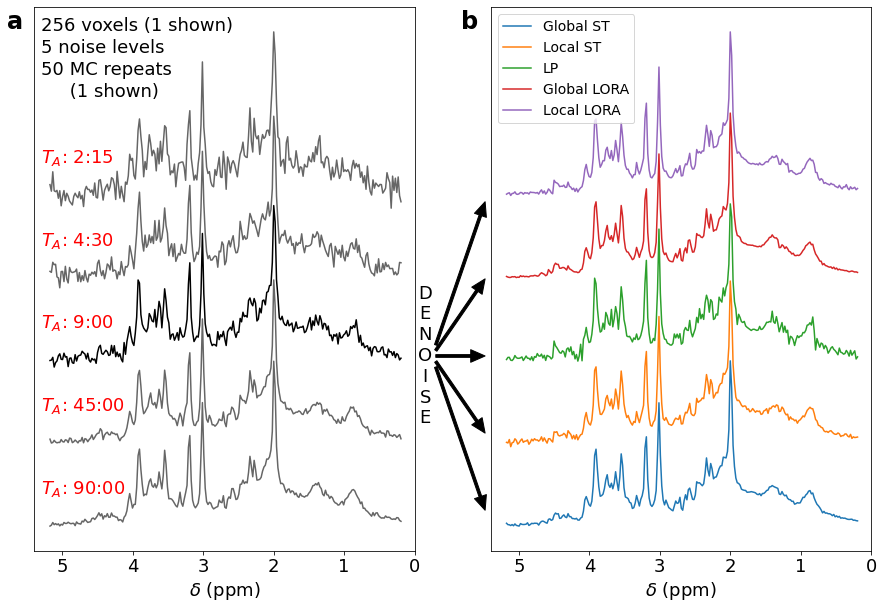

In [53]:
plt.rcParams.update({'font.size': 18})
plt.rc('legend', fontsize=14)    # legend fontsize

labels = ['Noisy', 'Global ST', 'Local ST', 'LP', 'Global LORA', 'Local LORA']
method_order = ['noisy', 'st_g', 'st_l', 'lp', 'lo_g', 'lo_l']
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,10))
yoffset = 0.0075
for idx, (mrs, scale) in enumerate(zip(noisy_fids, noise_scaling)):
    ta = 45/scale
    ta_sec = ta%1 * 60
    ta_min = np.floor(ta)
    if idx == 2:
        ax1.plot(mrs.getAxes(ppmlim=(0.2,5.2)),
                 yoffset * idx + mrs.get_spec(ppmlim=(0.2,5.2)).real,
                 'k')
    else:
        ax1.plot(mrs.getAxes(ppmlim=(0.2,5.2)),
                 yoffset * idx + mrs.get_spec(ppmlim=(0.2,5.2)).real,
                 color=(0.4,0.4,0.4))
    ax1.text(5.3, yoffset * idx + 0.003, f'$T_A$: {ta_min:0.0f}:{ta_sec:02.0f}',color='r')
ax1.set_xlim([5.4, 0])
ax1.set_yticks([])
ax1.set_xlabel('$\delta$ (ppm)')
for idx, mrskey in enumerate(method_order[1:]):
    ax2.plot(denoised_fids[mrskey].getAxes(ppmlim=(0.2,5.2)),
             yoffset * idx + denoised_fids[mrskey].get_spec(ppmlim=(0.2,5.2)).real,
             label=labels[idx+1])
ax2.set_xlim([5.4, 0])
ax2.set_yticks([])
ax2.legend()
ax2.set_xlabel('$\delta$ (ppm)')

prop = dict(arrowstyle="simple,head_width=0.7,head_length=0.8,tail_width=0.15",
            shrinkA=0,shrinkB=0,
            color='black')
ax1.annotate("", xy=(-1,0.0155), xytext=(-0.3,0.0155), arrowprops=prop, annotation_clip=False)
ax1.annotate("", xy=(-1,0.0155 + 0.007), xytext=(-0.3,0.0155 + 0.0005), arrowprops=prop, annotation_clip=False)
ax1.annotate("", xy=(-1,0.0155 - 0.007), xytext=(-0.3,0.0155 - 0.0005), arrowprops=prop, annotation_clip=False)
ax1.annotate("", xy=(-1,0.0155 + 0.014), xytext=(-0.3,0.0155 + 0.001), arrowprops=prop, annotation_clip=False)
ax1.annotate("", xy=(-1,0.0155 - 0.014), xytext=(-0.3,0.0155 - 0.001), arrowprops=prop, annotation_clip=False)

ax1.text(5.3, 0.045, '256 voxels (1 shown)')
ax1.text(5.3, 0.043, '5 noise levels')
ax1.text(5.3, 0.041, '50 MC repeats')
ax1.text(5.3, 0.039, '     (1 shown)')
ax1.text(-0.15, 0.0155, '\n'.join('DENOISE'), va='center', ha='center')

fig.text(0.10, 0.85,'a',fontweight='bold',fontsize=24)
fig.text(0.52, 0.85,'b',fontweight='bold',fontsize=24)

plt.savefig('figures/figure_1_synthetic_explanatory.png', bbox_inches='tight', dpi=300)
# plt.show()